# Decentmon data preparation

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from decmon.constants import *
from decmon.df_utils import *
from decmon.filter import *
from decmon.plotter import *

In [2]:
SUBDIR = "7"

In [3]:
path = f"{INPUT_DIR}/{SUBDIR}"

f_df = [load_simulation_data(f"{path}/{i}_output.log") for i in PATTERNS]
f_df[0].head()

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,0,1,2,3,3,7,7,2,1.0,4.07,1.0,8,21,12,"Until (Var ""c"", Var ""f"")",{ |b|c|d| | |g} ; { |b| | |e|f|g} ; {a| | | |...
1,1,1,2,4,3,7,9,2,1.0,3.09,1.0,8,36,12,"Until (Var ""b"", Var ""g"")",{a|b| | |e| | } ; { | |c|d| |f| } ; {a| |c|d|...
2,2,1,3,4,3,14,6,0,1.0,1.42,0.0,6,20,6,"Glob (Var ""a"")",{a|b|c|d| | | } ; {a| | | | |f|g} ; { |b|c| |...
3,3,1,2,3,2,7,0,0,1.0,0.00,0.0,3,7,3,"Next (Var ""d"")",{a|b| | |e|f| } ; {a| |c| | | |g} ; { |b|c| |...
4,4,1,2,3,2,7,0,0,1.0,0.00,0.0,3,7,3,"Next (Var ""e"")",{a| |c|d|e|f| } ; { |b|c|d|e|f|g} ; { | | |d|...


In [4]:
strategies_f_df = [split_by_dictionary(f_df[i], STRATEGIES) for i in PATTERNS]

print(f"Datasets: {len(strategies_f_df)}. Strategies: {len(strategies_f_df[0])}. Single dataset Formulae:{len(strategies_f_df[0][0])}")
sep_strat_f_df = [pd.concat(strategies_f_df[i], ignore_index=True) for i in PATTERNS]
sep_strat_f_df[0].head()

Datasets: 8. Strategies: 3. Single dataset Formulae:5111


,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,0,1,2,7,1.0,8,"Until (Var ""c"", Var ""f"")",{ |b|c|d| | |g} ; { |b| | |e|f|g} ; {a| | | |...,orchestration
1,1,1,2,7,1.0,8,"Until (Var ""b"", Var ""g"")",{a|b| | |e| | } ; { | |c|d| |f| } ; {a| |c|d|...,orchestration
2,2,1,3,14,1.0,6,"Glob (Var ""a"")",{a|b|c|d| | | } ; {a| | | | |f|g} ; { |b|c| |...,orchestration
3,3,1,2,7,1.0,3,"Next (Var ""d"")",{a|b| | |e|f| } ; {a| |c| | | |g} ; { |b|c| |...,orchestration
4,4,1,2,7,1.0,3,"Next (Var ""e"")",{a| |c|d|e|f| } ; { |b|c|d|e|f|g} ; { | | |d|...,orchestration


In [5]:
merged_metrics_df = [extract_metrics(sep_strat_f_df[i]) for i in PATTERNS]
merged_metrics_df[0].head()

,formula_id,strategy,value,metric
0,0,orchestration,2.0,trace_len
1,1,orchestration,2.0,trace_len
2,2,orchestration,3.0,trace_len
3,3,orchestration,2.0,trace_len
4,4,orchestration,2.0,trace_len


In [6]:
df_f_ops = [extract_ops(sep_strat_f_df[i]) for i in PATTERNS]
df_f_ops[0].head()

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,10,-3,-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,-2,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,-4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plotting

In [7]:
# for i in patterns:
#     grid_plot = plot_grid_barplots(merged_metrics_df[i], grid_cell_field= 'metric',
#               y_axis = 'value', x_axis = 'strategy',
#               order = ['orchestration', 'migration', 'choreography'])

#grid_plot.savefig("output/out.png")

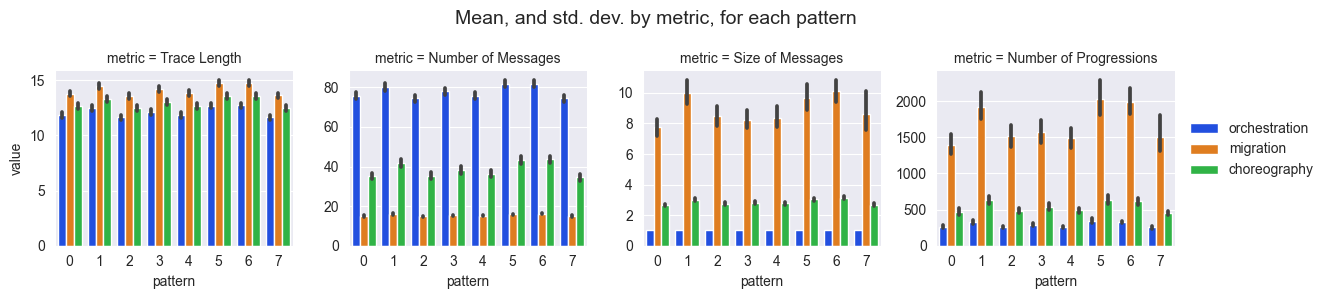

In [8]:
merged_metrics_dfp = prepare_with_pattern(merged_metrics_df)
plot = plot_metrics_by_patterns(merged_metrics_dfp)
plot.savefig(f"output/pattern_{SUBDIR}.png")
plot

In [10]:
expanded_f_df = [sep_strat_f_df[i].merge(df_f_ops[i], left_index=True, right_index=True) for i in PATTERNS]
expanded_f_df[0].head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,227,228,229,230,231,232,233,234,235,236
0,0,1,2,7,1.0,8,"Until (Var ""c"", Var ""f"")",{ |b|c|d| | |g} ; { |b| | |e|f|g} ; {a| | | |...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,7,1.0,8,"Until (Var ""b"", Var ""g"")",{a|b| | |e| | } ; { | |c|d| |f| } ; {a| |c|d|...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,3,14,1.0,6,"Glob (Var ""a"")",{a|b|c|d| | | } ; {a| | | | |f|g} ; { |b|c| |...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,7,1.0,3,"Next (Var ""d"")",{a|b| | |e|f| } ; {a| |c| | | |g} ; { |b|c| |...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,7,1.0,3,"Next (Var ""e"")",{a| |c|d|e|f| } ; { |b|c|d|e|f|g} ; { | | |d|...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
for i in PATTERNS:
    expanded_f_df[i].strategy = pd.Categorical(expanded_f_df[i].strategy)
    expanded_f_df[i]['strategy_id'] = expanded_f_df[i].strategy.cat.codes

full_scale_df_7 = pd.concat(expanded_f_df)
full_scale_df_7.head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,331,332,333,334,335,336,337,338,339,340
0,0,1,2,7,1.0,8,"Until (Var ""c"", Var ""f"")",{ |b|c|d| | |g} ; { |b| | |e|f|g} ; {a| | | |...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,7,1.0,8,"Until (Var ""b"", Var ""g"")",{a|b| | |e| | } ; { | |c|d| |f| } ; {a| |c|d|...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,3,14,1.0,6,"Glob (Var ""a"")",{a|b|c|d| | | } ; {a| | | | |f|g} ; { |b|c| |...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,7,1.0,3,"Next (Var ""d"")",{a|b| | |e|f| } ; {a| |c| | | |g} ; { |b|c| |...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,7,1.0,3,"Next (Var ""e"")",{a| |c|d|e|f| } ; { |b|c|d|e|f|g} ; { | | |d|...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
merged_metrics_dfp[0]

,index,strategy,value,metric,pattern
0,0,orchestration,2.0,trace_len,0
1,1,orchestration,2.0,trace_len,0
2,2,orchestration,3.0,trace_len,0
3,3,orchestration,2.0,trace_len,0
4,4,orchestration,2.0,trace_len,0
...,...,...,...,...,...
61327,15328,choreography,626.0,nb_progressions,0
61328,15329,choreography,2243.0,nb_progressions,0
61329,15330,choreography,81960.0,nb_progressions,0
61330,15331,choreography,1811.0,nb_progressions,0


In [13]:
test = pd.concat(merged_metrics_dfp)
test

,index,strategy,value,metric,pattern
0,0,orchestration,2.0,trace_len,0
1,1,orchestration,2.0,trace_len,0
2,2,orchestration,3.0,trace_len,0
3,3,orchestration,2.0,trace_len,0
4,4,orchestration,2.0,trace_len,0
...,...,...,...,...,...
62155,15535,choreography,256.0,nb_progressions,7
62156,15536,choreography,373.0,nb_progressions,7
62157,15537,choreography,2873.0,nb_progressions,7
62158,15538,choreography,104.0,nb_progressions,7
